In [2]:
# --- 1. 환경 설정 셀 (수정된 버전) ---
import os
import sys

# 작업 디렉토리를 올바른 위치로 변경
workspace_path = '/workspace'
os.chdir(workspace_path)

# RFdiffusion 경로를 파이썬이 인식하도록 추가
rfdiffusion_path = os.path.join(workspace_path, 'RFdiffusion')
if rfdiffusion_path not in sys.path:
    sys.path.append(rfdiffusion_path)
import time
import signal
import sys
import random
import string
import re
import json
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, HTML
import ipywidgets as widgets
import py3Dmol

# Colab이 아닌 로컬 환경이므로, RFdiffusion 경로를 직접 추가
if 'RFdiffusion' not in sys.path:
    home_dir = os.path.expanduser("~")
    rfdiffusion_path = os.path.join(home_dir, 'RFdiffusion')
    sys.path.append(rfdiffusion_path)

os.environ["DGLBACKEND"] = "pytorch"

from inference.utils import parse_pdb
from colabdesign.rf.utils import get_ca
from colabdesign.rf.utils import fix_contigs, fix_partial_contigs, fix_pdb, sym_it
from colabdesign.shared.protein import pdb_to_string
from colabdesign.shared.plot import plot_pseudo_3D

# --- Colab의 files.upload()를 대체하는 로컬 파일 처리 함수 ---
def get_pdb(pdb_code=None, use_upload=False):
    if use_upload:
        upload_widget = widgets.FileUpload(
            accept='.pdb', description='PDB 파일 업로드', button_style='info'
        )
        display(upload_widget)
        
        def wait_for_upload(widget):
            while len(widget.value) == 0: time.sleep(0.1)
            uploaded_filename = list(widget.value.keys())[0]
            pdb_content = widget.value[uploaded_filename]['content']
            pdb_filename = "tmp.pdb"
            with open(pdb_filename, "wb") as out: out.write(pdb_content)
            print(f"'{uploaded_filename}'이(가) 'tmp.pdb'로 저장되었습니다.")
            return pdb_filename
            
        return wait_for_upload(upload_widget)
    elif pdb_code is None or pdb_code == "":
        print("PDB 코드를 입력하거나 use_upload=True로 설정하세요.")
        return None
    elif os.path.isfile(pdb_code): return pdb_code
    elif len(pdb_code) == 4:
        pdb_filename = f"{pdb_code}.pdb1"
        if not os.path.isfile(pdb_filename):
            os.system(f"wget -qnc https://files.rcsb.org/download/{pdb_code}.pdb1.gz && gunzip -f {pdb_code}.pdb1.gz")
        return pdb_filename
    else:
        pdb_filename = f"AF-{pdb_code}-F1-model_v4.pdb"
        if not os.path.isfile(pdb_filename):
            os.system(f"wget -qnc https://alphafold.ebi.ac.uk/files/{pdb_filename}")
        return pdb_filename

def run_ananas(pdb_str, path, sym=None):
    pdb_filename = f"outputs/{path}/ananas_input.pdb"
    out_filename = f"outputs/{path}/ananas.json"
    os.makedirs(f"outputs/{path}", exist_ok=True)
    with open(pdb_filename,"w") as handle: handle.write(pdb_str)
    cmd = f"./ananas {pdb_filename} -u -j {out_filename}"
    if sym is None: os.system(cmd)
    else: os.system(f"{cmd} {sym}")
    try:
        with open(out_filename,"r") as f: out = json.load(f)
        results, AU = out[0], out[-1]["AU"]
        group, chains, rmsd = AU["group"], AU["chain names"], results["Average_RMSD"]
        print(f"AnAnaS detected {group} symmetry at RMSD:{rmsd:.3}")
        C = np.array(results['transforms'][0]['CENTER'])
        A = [np.array(t["AXIS"]) for t in results['transforms']]
        new_lines = []
        for line in pdb_str.split("\n"):
            if line.startswith("ATOM"):
                chain = line[21:22]
                if chain in chains:
                    x = np.array([float(line[i:(i+8)]) for i in [30,38,46]])
                    if group[0] == "c": x = sym_it(x,C,A[0])
                    if group[0] == "d": x = sym_it(x,C,A[1],A[0])
                    coord_str = "".join([f"{a:8.3f}" for a in x])
                    new_lines.append(line[:30]+coord_str+line[54:])
            else: new_lines.append(line)
        return results, "\n".join(new_lines)
    except Exception as e:
        print(f"AnAnaS 결과 처리 중 오류 발생: {e}")
        return None, pdb_str

def run(command, steps, num_designs=1, visual="none"):
    def run_command_and_get_pid(command):
        pid_file = '/dev/shm/pid'
        os.system(f'nohup {command} > /dev/null & echo $! > {pid_file}')
        with open(pid_file, 'r') as f: pid = int(f.read().strip())
        os.remove(pid_file)
        return pid
    def is_process_running(pid):
        try: os.kill(pid, 0)
        except OSError: return False
        else: return True
    run_output = widgets.Output()
    progress = widgets.FloatProgress(min=0, max=1, description='running', bar_style='info')
    display(widgets.VBox([progress, run_output]))
    for n in range(steps):
        if os.path.isfile(f"/dev/shm/{n}.pdb"): os.remove(f"/dev/shm/{n}.pdb")
    pid = run_command_and_get_pid(command)
    try:
        fail = False
        for _ in range(num_designs):
            for n in range(steps):
                wait = True
                while wait and not fail:
                    time.sleep(0.1)
                    if os.path.isfile(f"/dev/shm/{n}.pdb"):
                        with open(f"/dev/shm/{n}.pdb", "r") as f: pdb_str = f.read()
                        if "TER" in pdb_str or "ENDMDL" in pdb_str: wait = False
                        elif not is_process_running(pid): fail = True
                    elif not is_process_running(pid): fail = True
                if fail:
                    progress.bar_style = 'danger'; progress.description = "failed"
                    break
                else:
                    progress.value = (n+1) / steps
                    if visual != "none":
                        with run_output:
                            run_output.clear_output(wait=True)
                            if visual == "image":
                                xyz, bfact = get_ca(f"/dev/shm/{n}.pdb", get_bfact=True)
                                fig = plt.figure(); fig.set_dpi(100);fig.set_figwidth(6);fig.set_figheight(6)
                                ax1 = fig.add_subplot(111);ax1.set_xticks([]);ax1.set_yticks([])
                                plot_pseudo_3D(xyz, c=bfact, cmin=0.5, cmax=0.9, ax=ax1); plt.show()
                            if visual == "interactive":
                                view = py3Dmol.view(js='https://3dmol.org/build/3Dmol.js')
                                view.addModel(pdb_str,'pdb'); view.setStyle({'cartoon': {'colorscheme': {'prop':'b','gradient': 'roygb','min':0.5,'max':0.9}}})
                                view.zoomTo(); view.show()
                if os.path.exists(f"/dev/shm/{n}.pdb"): os.remove(f"/dev/shm/{n}.pdb")
            if fail:
                progress.bar_style = 'danger'; progress.description = "failed"
                break
        while is_process_running(pid): time.sleep(0.1)
    except KeyboardInterrupt:
        os.kill(pid, signal.SIGTERM); progress.bar_style = 'danger'; progress.description = "stopped"
    
def run_diffusion(contigs, path, pdb=None, iterations=50, symmetry="none", order=1, hotspot=None,
                  chains=None, add_potential=False, num_designs=1, visual="none"):
    full_path = f"outputs/{path}"; os.makedirs(full_path, exist_ok=True)
    opts = [f"inference.output_prefix={full_path}", f"inference.num_designs={num_designs}"]
    if chains == "": chains = None
    if symmetry in ["auto","cyclic","dihedral"]:
        if symmetry == "auto": sym, copies = None, 1
        else: sym, copies = {"cyclic":(f"c{order}",order), "dihedral":(f"d{order}",order*2)}[symmetry]
    else: symmetry = None; sym, copies = None, 1
    contigs_list = contigs.replace(","," ").replace(":"," ").split()
    is_fixed, is_free = False, False; fixed_chains = []
    for contig in contigs_list:
        for x in contig.split("/"):
            a = x.split("-")[0]
            if a and a[0].isalpha():
                is_fixed = True
                if a[0] not in fixed_chains: fixed_chains.append(a[0])
            if a.isnumeric(): is_free = True
    if len(contigs_list) == 0 or not is_free: mode = "partial"
    elif is_fixed: mode = "fixed"
    else: mode = "free"
    if mode in ["partial","fixed"]:
        pdb_str = pdb_to_string(pdb, chains=chains)
        if symmetry == "auto":
            a, pdb_str = run_ananas(pdb_str, path)
            if a is None: print(f'ERROR: no symmetry detected'); symmetry = None; sym, copies = None, 1
            else:
                if a["group"][0] == "c": symmetry = "cyclic"; sym, copies = a["group"], int(a["group"][1:])
                elif a["group"][0] == "d": symmetry = "dihedral"; sym, copies = a["group"], 2 * int(a["group"][1:])
                else: print(f'ERROR: detected symm ({a["group"]}) not supported'); symmetry = None; sym, copies = None, 1
        elif mode == "fixed": pdb_str = pdb_to_string(pdb_str, chains=fixed_chains)
        pdb_filename = f"{full_path}/input.pdb"
        with open(pdb_filename, "w") as handle: handle.write(pdb_str)
        parsed_pdb = parse_pdb(pdb_filename)
        opts.append(f"inference.input_pdb={pdb_filename}")
        if mode in ["partial"]:
            iterations = int(80 * (iterations / 200)); opts.append(f"diffuser.partial_T={iterations}")
            contigs_list = fix_partial_contigs(contigs_list, parsed_pdb)
        else: opts.append(f"diffuser.T={iterations}"); contigs_list = fix_contigs(contigs_list, parsed_pdb)
    else:
        opts.append(f"diffuser.T={iterations}"); parsed_pdb = None
        contigs_list = fix_contigs(contigs_list, parsed_pdb)
    if hotspot is not None and hotspot != "": opts.append(f"ppi.hotspot_res=[{hotspot}]")
    if sym is not None:
        sym_opts = ["--config-name symmetry", f"inference.symmetry={sym}"]
        if add_potential: sym_opts += ["'potentials.guiding_potentials=[\"type:olig_contacts,weight_intra:1,weight_inter:0.1\"]'", "potentials.olig_intra_all=True","potentials.olig_inter_all=True", "potentials.guide_scale=2","potentials.guide_decay=quadratic"]
        opts = sym_opts + opts; contigs_list = sum([contigs_list] * copies,[])
    opts.append(f"'contigmap.contigs=[{' '.join(contigs_list)}]'")
    opts += ["inference.dump_pdb=True","inference.dump_pdb_path='/dev/shm'"]
    print("mode:", mode); print("output:", full_path); print("contigs:", contigs_list)
    run_script_path = "/workspace/RFdiffusion/run_inference.py"
    opts_str = " ".join(opts)
    cmd = f"python {run_script_path} {opts_str}"
    print(cmd)
    run(cmd, iterations, num_designs, visual=visual)
    for n in range(num_designs):
        pdbs = [f"outputs/traj/{path}_{n}_pX0_traj.pdb", f"outputs/traj/{path}_{n}_Xt-1_traj.pdb", f"{full_path}_{n}.pdb"]
        for pdb_file in pdbs:
            if os.path.exists(pdb_file):
                with open(pdb_file,"r") as handle: pdb_str = handle.read()
                with open(pdb_file,"w") as handle: handle.write(fix_pdb(pdb_str, contigs_list))
    return contigs_list, copies

print("✅ Setup cell is ready.")

✅ Setup cell is ready.


✅ 결과가 저장될 폴더: outputs/0825-50-600_9b08r
mode: fixed
output: outputs/0825-50-600_9b08r/0825-50-600_9b08r
contigs: ['C311-391', '100-100']
python /workspace/RFdiffusion/run_inference.py inference.output_prefix=outputs/0825-50-600_9b08r/0825-50-600_9b08r inference.num_designs=600 inference.input_pdb=outputs/0825-50-600_9b08r/0825-50-600_9b08r/input.pdb diffuser.T=50 ppi.hotspot_res=[C331,C360,C378,C381,C323] 'contigmap.contigs=[C311-391 100-100]' inference.dump_pdb=True inference.dump_pdb_path='/dev/shm'


/workspace/RFdiffusion/util_module.py:259: UserWarning: Using torch.cross without specifying the dim arg is deprecated.
Please either pass the dim explicitly or simply use torch.linalg.cross.
The default value of dim will change to agree with that of linalg.cross in a future release. (Triggered internally at /opt/pytorch/pytorch/aten/src/ATen/native/Cross.cpp:62.)
  CBrotaxis1 = (CBr-CAr).cross(NCr-CAr)


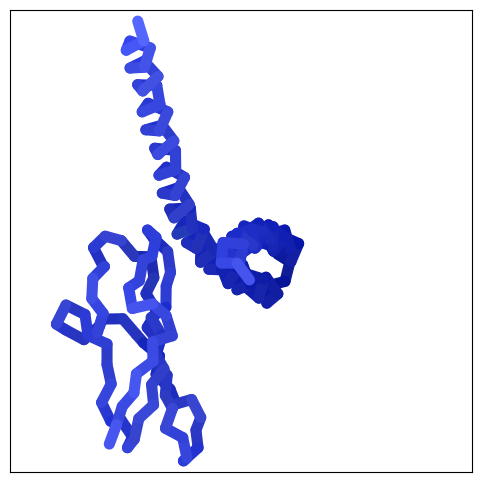

In [ ]:
# --- 바인더 디자인 실행 셀 (수정된 버전) ---

# 1. 파라미터 설정
name = "0825-50-600"
contigs = "C311-391/0 100-100"
hotspot = "C331,C360,C378,C381,C323"
iterations = 50
num_designs = 600
visual = "image"

# --- 2. 업로드한 PDB 파일 경로 직접 지정 ---
# 여기에 1단계에서 업로드한 PDB 파일의 정확한 이름을 입력하세요.
pdb_filename = "4k9e_c.pdb" 
pdb = os.path.join("/workspace", pdb_filename)

# 3. RFdiffusion 실행
# --- 이 아랫부분이 수정되었습니다 ---

# 기본 실행 이름(폴더명으로 사용될)을 설정합니다.
base_name = name
output_dir = f"outputs/{base_name}"

# 만약 동일한 이름의 폴더가 이미 존재하면, 중복을 피하기 위해 랜덤 문자열을 뒤에 붙입니다.
while os.path.exists(output_dir):
    random_suffix = ''.join(random.choices(string.ascii_lowercase + string.digits, k=5))
    base_name = f"{name}_{random_suffix}"
    output_dir = f"outputs/{base_name}"

# run_diffusion 함수는 이 path를 파일 이름의 접두사로 사용합니다.
# 예: path가 "8051/8051" 이면, 결과는 outputs/8051/8051_0.pdb 로 저장됩니다.
path = os.path.join(base_name, base_name)

print(f"✅ 결과가 저장될 폴더: {output_dir}")
# --- 수정된 부분 끝 ---


flags = {
    "contigs": contigs, "pdb": pdb, "iterations": int(iterations),
    "hotspot": hotspot, "path": path, "num_designs": int(num_designs),
    "visual": visual, "symmetry": "none", "order": 1, "chains": "", "add_potential": True
}

for k, v in flags.items():
    if isinstance(v, str):
        flags[k] = v.replace("'", "").replace('"', '')

contigs, copies = run_diffusion(**flags)

# --- 마지막 출력 메시지도 수정되었습니다 ---
print(f"✅ RFdiffusion 실행 완료! 결과는 '{output_dir}' 폴더에 저장되었습니다.")

In [ ]:
# 아래 코드는 backbone만 있어도 proteinmpnn,colabdesign을 실행시켜주는 코드 * 코드 이상함 다시 짜기 *

In [3]:
# --- [파일 이름 정리 코드] ---
import os
import glob
import re

# @markdown ### **👇 정리할 RFdiffusion 실행 폴더 이름을 입력하세요.**
run_name = "0826-50-600_ocr8j"  # @param {type:"string"}

# --- 아래 코드는 그대로 실행하면 됩니다. ---

# 대상 폴더 경로 설정
target_dir = os.path.join("outputs", run_name)

if not os.path.isdir(target_dir):
    print(f"🚨 에러: '{target_dir}' 폴더를 찾을 수 없습니다. 'run_name'을 확인해주세요.")
else:
    # 해당 폴더 내의 모든 pdb 파일 목록을 가져옵니다.
    pdb_files = sorted(glob.glob(os.path.join(target_dir, f"{run_name}_*.pdb")))
    
    if not pdb_files:
        print(f"🚨 에러: '{target_dir}' 폴더에서 PDB 파일을 찾을 수 없습니다.")
    else:
        print(f"✅ 총 {len(pdb_files)}개의 PDB 파일을 찾았습니다. 파일 이름 변경을 시작합니다...")
        
        # 새로운 번호로 파일 이름을 변경합니다.
        for i, old_pdb_path in enumerate(pdb_files):
            # 새 파일 경로 생성 (예: .../run_name_0.pdb)
            new_pdb_path = os.path.join(target_dir, f"{run_name}_{i}.pdb")
            
            # 연관된 .trb 파일 경로도 생성
            old_trb_path = old_pdb_path.replace(".pdb", ".trb")
            new_trb_path = new_pdb_path.replace(".pdb", ".trb")
            
            # 파일 이름 변경 실행
            if old_pdb_path != new_pdb_path:
                print(f"  - Renaming {os.path.basename(old_pdb_path)} -> {os.path.basename(new_pdb_path)}")
                os.rename(old_pdb_path, new_pdb_path)
            
            if os.path.exists(old_trb_path) and old_trb_path != new_trb_path:
                print(f"  - Renaming {os.path.basename(old_trb_path)} -> {os.path.basename(new_trb_path)}")
                os.rename(old_trb_path, new_trb_path)

        print("\n✅ 파일 이름 정리가 완료되었습니다. 이제 검증 스크립트를 실행할 수 있습니다.")

✅ 총 600개의 PDB 파일을 찾았습니다. 파일 이름 변경을 시작합니다...
  - Renaming 0826-50-600_ocr8j_10.pdb -> 0826-50-600_ocr8j_2.pdb
  - Renaming 0826-50-600_ocr8j_10.trb -> 0826-50-600_ocr8j_2.trb
  - Renaming 0826-50-600_ocr8j_100.pdb -> 0826-50-600_ocr8j_3.pdb
  - Renaming 0826-50-600_ocr8j_100.trb -> 0826-50-600_ocr8j_3.trb
  - Renaming 0826-50-600_ocr8j_101.pdb -> 0826-50-600_ocr8j_4.pdb
  - Renaming 0826-50-600_ocr8j_101.trb -> 0826-50-600_ocr8j_4.trb
  - Renaming 0826-50-600_ocr8j_102.pdb -> 0826-50-600_ocr8j_5.pdb
  - Renaming 0826-50-600_ocr8j_102.trb -> 0826-50-600_ocr8j_5.trb
  - Renaming 0826-50-600_ocr8j_103.pdb -> 0826-50-600_ocr8j_6.pdb
  - Renaming 0826-50-600_ocr8j_103.trb -> 0826-50-600_ocr8j_6.trb
  - Renaming 0826-50-600_ocr8j_104.pdb -> 0826-50-600_ocr8j_7.pdb
  - Renaming 0826-50-600_ocr8j_104.trb -> 0826-50-600_ocr8j_7.trb
  - Renaming 0826-50-600_ocr8j_105.pdb -> 0826-50-600_ocr8j_8.pdb
  - Renaming 0826-50-600_ocr8j_105.trb -> 0826-50-600_ocr8j_8.trb
  - Renaming 0826-50-600_ocr8j_106

In [2]:
# --- Top n 디자인을 선별하고 PDB 파일을 생성하는 셀 ---

import pandas as pd
import os
import shutil

# 1. 결과 파일 및 경로 설정 (이 부분은 이미 올바르게 수정되었습니다)
results_csv_path = "outputs/0825-50-600_9b08r/0825-50-600_9b08r/mpnn_results.csv"
source_pdb_folder = "outputs/0825-50-600_9b08r/0825-50-600_9b08r"
ranked_pdb_folder = "outputs/0825-50-600_9b08r/0825-50-600_9b08r/ranked_top_100"

print(f"'{results_csv_path}' 파일에서 결과 분석을 시작합니다.")

# 2. 결과 파일이 있는지 확인
if not os.path.exists(results_csv_path):
    print(f" 에러: 결과 파일({results_csv_path})을 찾을 수 없습니다. 이전 셀이 성공적으로 실행되었는지 확인하세요.")
else:
    # 3. CSV 파일 읽어오기
    df_all = pd.read_csv(results_csv_path)
    
    # 4. i_pae < 10 조건으로 필터링
    #    'i_pae' 컬럼이 존재하므로 그대로 사용합니다.
    if 'i_pae' in df_all.columns:
        df_filtered = df_all[df_all['i_pae'] < 10].copy()
        print(f"i_pae < 10 조건을 만족하는 디자인 {len(df_filtered)}개를 찾았습니다.")
    else:
        print(" 경고: 'i_pae' 컬럼을 찾을 수 없습니다. 필터링 없이 모든 디자인으로 진행합니다.")
        df_filtered = df_all.copy()

    # 5. RMSD 기준으로 오름차순 정렬
    df_sorted = df_filtered.sort_values(by='rmsd', ascending=True)

    # 6. 상위 100개 디자인 선택
    top_100_designs = df_sorted.head(100)
    print(f"RMSD가 낮은 순서대로 상위 {len(top_100_designs)}개를 선별했습니다.")

    # 7. 순위별 PDB 파일을 저장할 폴더 생성
    os.makedirs(ranked_pdb_folder, exist_ok=True)
    print(f"선별된 PDB 파일은 '{ranked_pdb_folder}' 폴더에 저장됩니다.")

    # 8. PDB 파일 복사 및 이름 변경
    copied_count = 0
    for rank, (index, row) in enumerate(top_100_designs.iterrows(), 1):
        # 'design'과 'n' 컬럼을 조합하여 파일명 생성
        design_name = f"design{row['design']}_n{row['n']}"  # 이 부분을 수정
        source_pdb_file = f"{source_pdb_folder}/{design_name}.pdb"
        
        # 순위를 포함한 새로운 파일명 지정
        rmsd_val = row['rmsd']
        dest_pdb_file = f"{ranked_pdb_folder}/rank_{rank:03d}_{design_name}_rmsd_{rmsd_val:.2f}.pdb"

        if os.path.exists(source_pdb_file):
            shutil.copy(source_pdb_file, dest_pdb_file)
            copied_count += 1
        else:
            print(f"  - 경고: 원본 파일 '{source_pdb_file}'을 찾을 수 없습니다.")

    print(f"\n✅ 작업 완료: 총 {copied_count}개의 PDB 파일을 순위별로 저장했습니다.")
    
    # 9. 선별된 Top 100 디자인의 통계 정보 출력
    # 'name' 대신 'plddt', 'i_pae', 'rmsd' 컬럼을 출력합니다. 'design'과 'n'도 포함합니다.
    print("\n📊 선별된 Top 100 디자인 목록:")
    print(top_100_designs[['design', 'n', 'plddt', 'i_pae', 'rmsd']].to_string(index=False)) # 이 부분을 수정

'outputs/0825-50-600_9b08r/0825-50-600_9b08r/mpnn_results.csv' 파일에서 결과 분석을 시작합니다.
i_pae < 10 조건을 만족하는 디자인 18개를 찾았습니다.
RMSD가 낮은 순서대로 상위 18개를 선별했습니다.
선별된 PDB 파일은 'outputs/0825-50-600_9b08r/0825-50-600_9b08r/ranked_top_100' 폴더에 저장됩니다.
  - 경고: 원본 파일 'outputs/0825-50-600_9b08r/0825-50-600_9b08r/design553_n0.pdb'을 찾을 수 없습니다.
  - 경고: 원본 파일 'outputs/0825-50-600_9b08r/0825-50-600_9b08r/design553_n4.pdb'을 찾을 수 없습니다.
  - 경고: 원본 파일 'outputs/0825-50-600_9b08r/0825-50-600_9b08r/design553_n1.pdb'을 찾을 수 없습니다.
  - 경고: 원본 파일 'outputs/0825-50-600_9b08r/0825-50-600_9b08r/design553_n2.pdb'을 찾을 수 없습니다.
  - 경고: 원본 파일 'outputs/0825-50-600_9b08r/0825-50-600_9b08r/design553_n7.pdb'을 찾을 수 없습니다.
  - 경고: 원본 파일 'outputs/0825-50-600_9b08r/0825-50-600_9b08r/design553_n6.pdb'을 찾을 수 없습니다.
  - 경고: 원본 파일 'outputs/0825-50-600_9b08r/0825-50-600_9b08r/design103_n3.pdb'을 찾을 수 없습니다.
  - 경고: 원본 파일 'outputs/0825-50-600_9b08r/0825-50-600_9b08r/design366_n6.pdb'을 찾을 수 없습니다.
  - 경고: 원본 파일 'outputs/0825-50-600_9b08r/0825-50-600_9b0